#  Exploratory data analysis

## Questions/items to investigate
1. Date range
2. Missingness
4. Filters to add to data before modelling
    1. non-commercial carriers
    2. 'empty' carrier
3. Distribution of outcome variable
    1. alone
    2. by terminal
    3. by carrier
    

In [2]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#debug libraries needed
import requests
import os

In [3]:
#theme to something a bit nicer

sns.set(
    style='whitegrid', palette='Set2',
    rc={
        "figure.dpi": 100,
        "axes.spines.top": False,
        "axes.spines.right": False,
    },
)

In [4]:
#import data
data = pd.read_pickle('C:\\Users\\ellio\\Desktop\\Python\\scripts\\ML_flight_cancellation_prediction\\datasets\\2-formatted_data_for_EDA.pickle')
#check for formats
display(data.dtypes)

#groovy

type                                 object
status                               object
departure_iatacode                   object
departure_icaocode                   object
departure_terminal                   object
arrival_terminal                     object
airline_name                         object
flight_number                        object
flight_iatanumber                    object
codeshared_airline_name              object
codeshared_flight_number             object
departure_gate                       object
departure_estimatedrunway            object
departure_actualrunway               object
departure_scheduledtime      datetime64[ns]
arrival_scheduledtime        datetime64[ns]
departure_delay              datetime64[ns]
departure_estimatedtime      datetime64[ns]
departure_actualtime         datetime64[ns]
weekday                              object
time_of_day                          object
date                                 object
cancelled_outcome               

In [5]:
data.head(3)

,type,status,departure_iatacode,departure_icaocode,departure_terminal,arrival_terminal,airline_name,flight_number,flight_iatanumber,codeshared_airline_name,...,departure_actualrunway,departure_scheduledtime,arrival_scheduledtime,departure_delay,departure_estimatedtime,departure_actualtime,weekday,time_of_day,date,cancelled_outcome
0,departure,unknown,lhr,egll,2,5,thai airways international,6225,tg6225,sas,...,None,2020-05-15 06:40:00,2020-05-15 10:05:00,NaT,NaT,NaT,Friday,06:40:00,2020-05-15,0
1,departure,unknown,lhr,egll,2,5,sas,1530,sk1530,None,...,None,2020-05-15 06:40:00,2020-05-15 10:05:00,NaT,NaT,NaT,Friday,06:40:00,2020-05-15,0
2,departure,unknown,lhr,egll,2,3,sas,500,sk500,None,...,None,2020-05-15 06:45:00,2020-05-15 09:35:00,NaT,NaT,NaT,Friday,06:45:00,2020-05-15,0


In [6]:
display(min(data['departure_scheduledtime']))
display(max(data['departure_scheduledtime']))

#Date range from Jun 1 to Dec 25 2020

Timestamp('2020-05-15 06:40:00')

Timestamp('2020-12-25 22:30:00')

<AxesSubplot:>

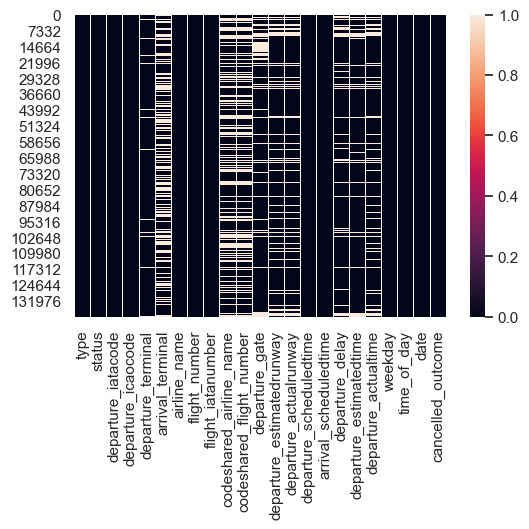

In [7]:
#missingness

sns.heatmap(data.isnull())

#lots
# need to remove anything to do with arrivals. 

status
active       127646
cancelled      4674
scheduled      2429
unknown        4543
Name: status, dtype: int64

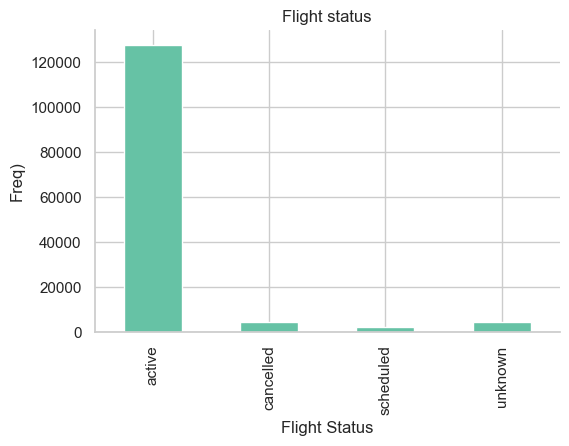

In [8]:
# check overall distribution of the outcome 
freq = data.groupby("status")['status'].count()
freq.plot(kind="bar", legend=None)
plt.xlabel("Flight Status")
plt.ylabel("Freq)")
plt.title("Flight status")
display(freq)

#severely imbalanced classification problem. May need up sampling.

In [9]:
# which carriers are the worst cancellers? - lots of carriers so plot the top 20 as a % of all flights as not all carriers have the same amount
def get_percentage_table(dataframe, v1, v2):
    '''returns a subtable with the counts and percentages of a 2 categorical columns in a pd dataframe
    
    Parameters
    ----------
    Inputs:
    dataframe : Pandas dataframe
    var1: string value of Pandas dataframe column which will become the index that will be grouped by 
    var2: string value of Pandas dataframe column which will become the counted values and percentages of var1
    
    Outputs:
    a dataframe with var1 as the rowIndex and a multi index of count and percentage values for var2
    
    '''
    
    data_short = dataframe[[v1, v2 ]]
    df2 = data_short.reset_index().groupby([v1, v2]).count().unstack('status').fillna(0)
    df2.columns.rename('Value',level=0, inplace=True)
    df2.columns = df2.columns.set_levels(['Count'], level=0)
    totals = df2.sum(axis=1)
    totals.name = ('Count', 'all')
    df3 = df2.divide(df2.sum(axis=1), axis=0)
    df3.columns = df3.columns.set_levels(['Percent'], level=0)
    dff = pd.concat([totals, df2, df3], axis=1)
    return dff

In [10]:
# print table
cancelled_per = get_percentage_table(data, 'airline_name', 'status')
cancelled_per

Count                                       Percent  \
                     all  active cancelled scheduled unknown    active   
airline_name                                                             
                    46.0    34.0       0.0       0.0    12.0  0.739130   
aegean airlines   1068.0  1017.0      31.0       5.0    15.0  0.952247   
aer lingus        4359.0  3884.0     102.0     118.0   255.0  0.891030   
aeroflot           288.0   265.0       0.0       3.0    20.0  0.920139   
aeromexico         623.0   576.0      19.0       6.0    22.0  0.924559   
...                  ...     ...       ...       ...     ...       ...   
virgin atlantic   2735.0  2574.0      93.0      54.0    14.0  0.941133   
virgin australia   481.0   478.0       0.0       3.0     0.0  0.993763   
vistara             65.0    61.0       1.0       2.0     1.0  0.938462   
vueling            480.0   438.0      33.0       5.0     4.0  0.912500   
xiamen airlines    638.0   617.0       8.0       5.0     8.0  0.967085   

                                                
                 cancelled scheduled   unknown  
airline_name                                    
                  0.000000  0.000000  0.260870  
aegean airlines   0.029026  0.004682  0.014045  
aer lingus        0.023400  0.027070  0.058500  
aeroflot          0.000000  0.010417  0.069444  
aeromexico        0.030498  0.009631  0.035313  
...                    ...       ...       ...  
virgin atlantic   0.034004  0.019744  0.005119  
virgin australia  0.000000  0.006237  0.000000  
vistara           0.015385  0.030769  0.015385  
vueling           0.068750  0.010417  0.008333  
xiamen airlines   0.012539  0.007837  0.012539  

[124 rows x 9 columns]

In [11]:
#Let's get some descriptive stats

cancelled_per['Percent']['cancelled'].describe()

count    124.000000
mean       0.031440
std        0.055080
min        0.000000
25%        0.000000
50%        0.017778
75%        0.032311
max        0.333333
Name: cancelled, dtype: float64

Text(0, 0.5, 'Carrier')

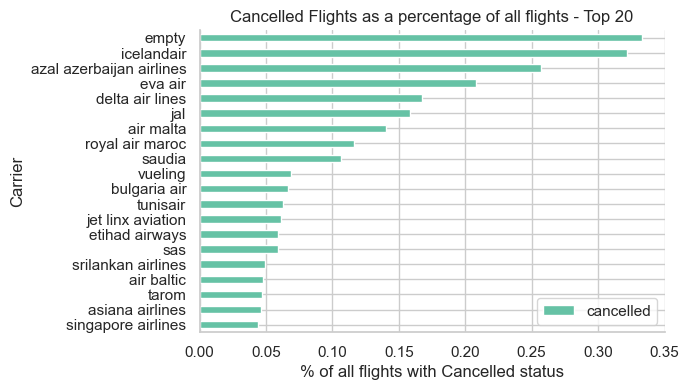

In [12]:
#plot top 20 carriers by % cancelled of all flights
cancelled_plot_df = cancelled_per['Percent']['cancelled'].sort_values(ascending=False)
cancelled_plot_top20 = cancelled_plot_df[0:20]
cancelled_plot_top20.plot(kind='barh').invert_yaxis()

plt.legend()
plt.title('Cancelled Flights as a percentage of all flights - Top 20')
plt.xlabel('% of all flights with Cancelled status')
plt.ylabel('Carrier')

- what is 'empty'? Likely small/private aircraft. Not something we want to model on. Especially with that high a cancellation frequency  
- Need a strategy for capturing information from the carrier as there are too many to encode and they all behave differently     
- Likely need to engineer a carrier size/frequency column - added to 4- Feature engineering

C:\Users\ellio\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ellio\Anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\ellio\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


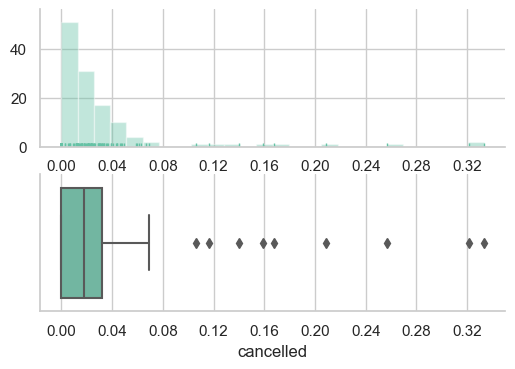

In [13]:
#let's look at the distribution of the rest of the flight cancellations 
fig, ax = plt.subplots(sharex = True)

plt.subplot(2, 1, 1)
sns.distplot(x = cancelled_plot_df, rug=True, kde=False).xaxis.set_major_locator(plt.MaxNLocator(10))
plt.subplot(2, 1, 2)
sns.boxplot(cancelled_plot_df).xaxis.set_major_locator(plt.MaxNLocator(10))

There is a lot of variability between carriers, it would be a good predictor of cancellations, but only for a small number of carriers. It looks as though most of the carriers have less than 2% cancellations as a percentage, with a vast majority less than 1%. 

In [14]:
# add to filters carriers with more than 0.08% of cancellations
cancelled_plot_df = cancelled_plot_df.to_frame()

good_carriers = cancelled_plot_df.loc[cancelled_plot_df['cancelled'] < 0.08].index


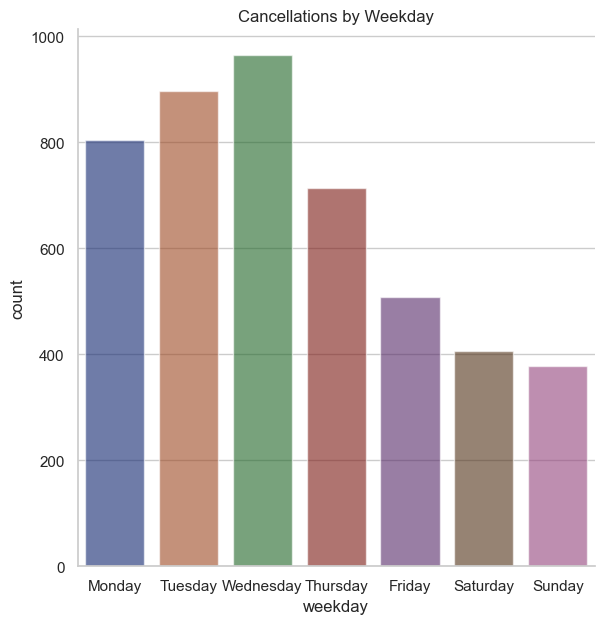

In [15]:
# Does day of the week have predictive ability for cancellations?
sns.catplot(
    data= data[data['cancelled_outcome'] == 1], kind="count",
    x="weekday", palette="dark", alpha=.6, height=6,
    order=['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).set(title = 'Cancellations by Weekday')

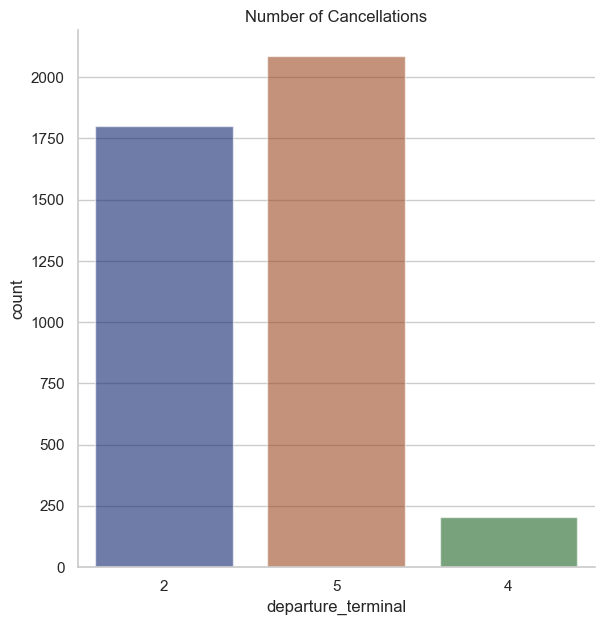

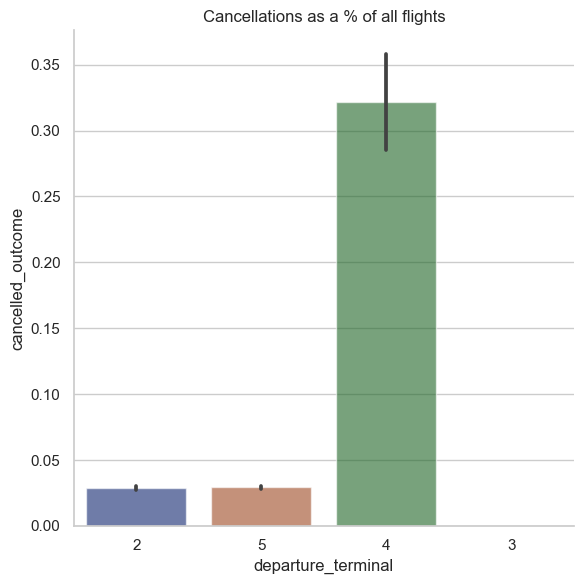

In [16]:
# Terminals - this one is odd. As a raw number the worst is terminal 2, but as a % of all flights 4 is an insane outlier - should examine closer
cancelled_only = data[data['cancelled_outcome'] == 1]

sns.catplot(
    data=cancelled_only, kind="count",
    x="departure_terminal",
    palette="dark", alpha=.6, height=6
    
).set(title = 'Number of Cancellations')

sns.catplot(
    data=data, kind="bar",
    x="departure_terminal", y = 'cancelled_outcome',
    palette="dark", alpha=.6, height=6
    
).set(title = 'Cancellations as a % of all flights')

plt.tight_layout()

Most flights seem to be departing from t2 and t5 - as flights departing from terminal 3 and 4 are minor, the % difference in cancellations coming from t4 may assign too much weight to terminal 4 when predicting cancellations - however as these flights are not common it is ok.

let's look at flights over time and see if there has been any changes.

__Note:__ The highlighted a failure in the query - skip 2 cells to see the fixed datasets. Leaving here 

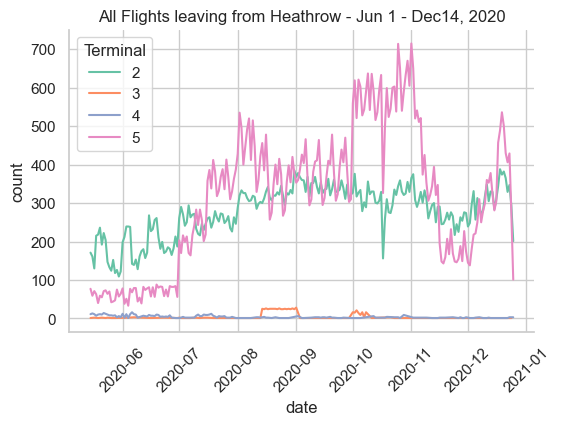

In [22]:
# All flights leaving heathrow

data_terminal_subset = data.groupby(["date",'departure_terminal'])['departure_terminal'].count().reset_index(name="count")
data_terminal_subset1 = data_terminal_subset
data_terminal_subset1.reset_index()

sns.lineplot(data=data_terminal_subset1, x="date", y="count", hue="departure_terminal").set(title = 'All Flights leaving from Heathrow - Jun 1 - Dec14, 2020')

plt.xticks(rotation=45)

plt.legend(loc = 'upper left', title = 'Terminal')

plt.savefig('All flights in Heathrow - missing data.png')

#seems as though there was a period of no flights in mid october I think our payload missed a period as we were querying 2 week intervals - recheck.

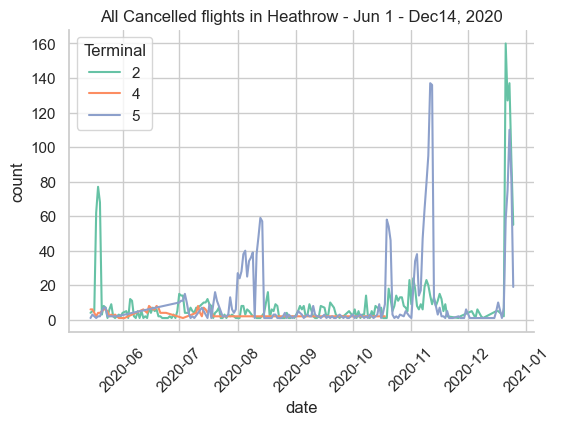

In [20]:
# cancelled flights only - same missing period

cancelled_data_terminal_subset = cancelled_only.groupby(["date",'departure_terminal'])['departure_terminal'].count().reset_index(name="count")
# data_terminal_subset1.reset_index()

sns.lineplot(data=cancelled_data_terminal_subset, x="date", y="count", hue="departure_terminal").set(title = 'All Cancelled flights in Heathrow - Jun 1 - Dec14, 2020')

plt.xticks(rotation=45)
plt.legend(loc = 'upper left', title = 'Terminal')

plt.savefig('Cancelled flights in Heathrow - missing data.png')

Same period with missing values. Let's check our query didn't miss any payloads

In [96]:
#check buggy paylod using the missing dates
os.chdir('C:\\Users\\ellio\\Desktop\\Python\\scripts\\ML_flight_cancellation_prediction\\1- API_scrape_dataset_build')

import requests
import ae_keys

url = 'http://aviation-edge.com/v2/public/flightsHistory?key=' # Our URL

key = ae_keys.api_key # import keys from local script - added to gitignore

payload = '&code=LHR&type=departure' # London Heathrow and departures only


payload_ls = [] #list to add each payload response to

start = date(2020, 10, 19) # start date

end = date(2020, 11, 4)

response = requests.get(url + str(key)+ payload + '&date_from=' + str(start) + '&date_to=' +str(end))

if response.status_code == 200:
    payload_ls.append(response.json())
    fs_df = pd.json_normalize(payload_ls[0])
    print('request returned something')
else:
    print('not a good request')

fs_df.head(10)

request returned something


,error,success
0,No Record Found,False


In [100]:
# logged another support ticket, looks like there is nothing I can do about these dates. Annoying. I could try increasing the system sleep and decreasing the interval to 10 days. 
# I don't have time now.


'2020-10-19'

Text(0, 0.5, 'Carrier')

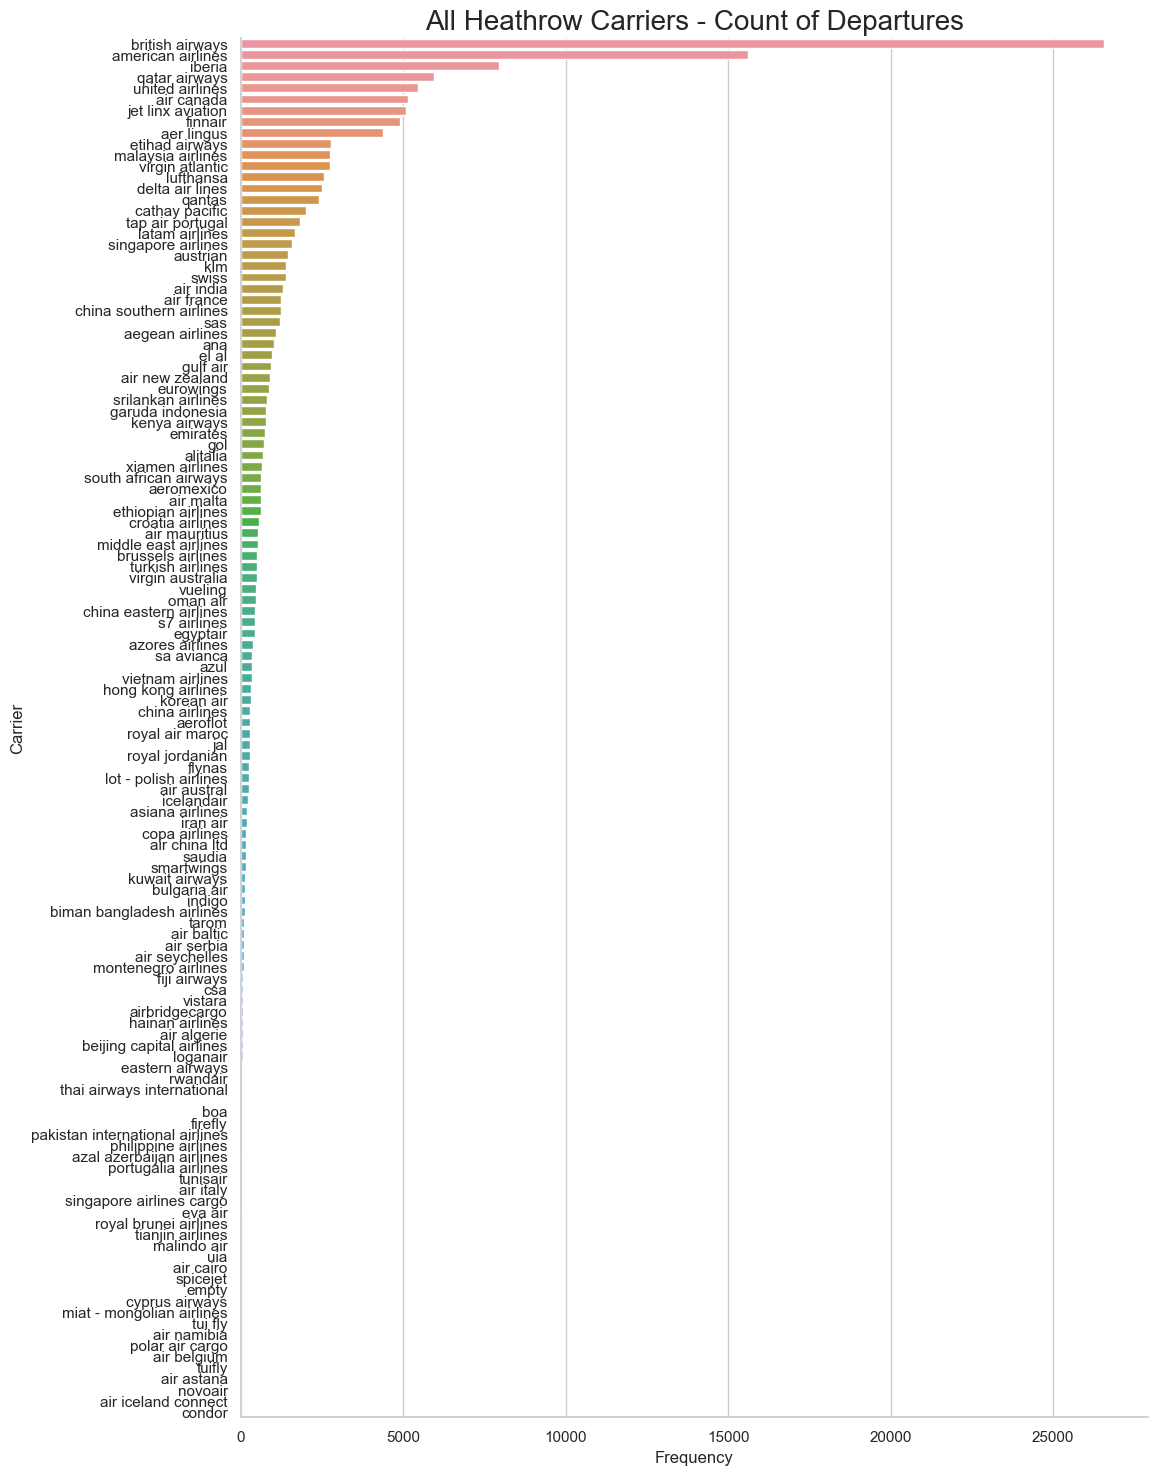

In [121]:
# need to understand the carriers - raw count plot
a4_dims = (11.7, 18.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.countplot(ax=ax, y="airline_name", data=data, order = data['airline_name'].value_counts().index)
plt.title('All Heathrow Carriers - Count of Departures', size = 20)
plt.xlabel('Frequency')
plt.ylabel('Carrier')

Feature engineer an ordered rank 5 - the most frequent departer of Heathrow (>3000) 1 - the least frequent departer (<50) - one hot encode as this is clearly not a linear relationship

Could scrape by other values 
- passengers here: https://en.wikipedia.org/wiki/Largest_airlines_in_the_world - Top 10 only
- Safety rating here: https://en.wikipedia.org/wiki/JACDEC - Top 10 only

Full data Available at IATA - World Air Transport Statistics for $4500, just outside my budget for a personal project...

In [122]:
data.to_pickle(path = 'C:\\Users\\ellio\\Desktop\\Python\\scripts\\ML_flight_cancellation_prediction\\datasets\\3-data_for_features.pickle')